In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monkeypox-patients-dataset/DATA.csv


## Importing libraries needed

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [20]:
#read the file
df = pd.read_csv("/kaggle/input/monkeypox-patients-dataset/DATA.csv")
df.columns = df.columns.str.replace(' ', '_')
df.head()

,Patient_ID,Systemic_Illness,Rectal_Pain,Sore_Throat,Penile_Oedema,Oral_Lesions,Solitary_Lesion,Swollen_Tonsils,HIV_Infection,Sexually_Transmitted_Infection,MonkeyPox
0,P0,None,False,True,True,True,False,True,False,False,Negative
1,P1,Fever,True,False,True,True,False,False,True,False,Positive
2,P2,Fever,False,True,True,False,False,False,True,False,Positive
3,P3,None,True,False,False,False,True,True,True,False,Positive
4,P4,Swollen Lymph Nodes,True,True,True,False,False,True,True,False,Positive


In [21]:
df.Systemic_Illness.value_counts()

Fever                    6382
Swollen Lymph Nodes      6252
None                     6216
Muscle Aches and Pain    6150
Name: Systemic_Illness, dtype: int64

In [22]:
tab = pd.crosstab(df['Systemic_Illness'], columns=df.MonkeyPox)
print(tab)

MonkeyPox              Negative  Positive
Systemic_Illness                         
Fever                      1602      4780
Muscle Aches and Pain      2926      3224
None                       2892      3324
Swollen Lymph Nodes        1671      4581


In [23]:
#Systemic_Illness need to be converted to integer. There are four types.
#We'll assign , 'Fever': 3, 'Swollen Lymph Nodes':2, 'Muscle Aches and Pain':1,'None':0
#This function will server in the conversion of train, validation and test data.
def convertData(df_feature, df_target):
    df_feature.Systemic_Illness = df_feature.Systemic_Illness.replace({'Fever': 3, 'Swollen Lymph Nodes':2, 'Muscle Aches and Pain':0,'None':1})
    df_feature[['Rectal_Pain', 'Sore_Throat','Penile_Oedema', 'Oral_Lesions', 'Solitary_Lesion', 'Swollen_Tonsils',
        'HIV_Infection', 'Sexually_Transmitted_Infection']] = df_feature[['Rectal_Pain', 'Sore_Throat','Penile_Oedema', 'Oral_Lesions', 'Solitary_Lesion', 'Swollen_Tonsils',
        'HIV_Infection', 'Sexually_Transmitted_Infection']].astype(int)
    df_target = df_target.replace({'Negative': 0, 'Positive':1})
    return df_feature, df_target

In [24]:
df.corr()

,Rectal_Pain,Sore_Throat,Penile_Oedema,Oral_Lesions,Solitary_Lesion,Swollen_Tonsils,HIV_Infection,Sexually_Transmitted_Infection
Rectal_Pain,1.000000,0.006214,0.005312,0.007747,0.001147,0.002113,0.005764,0.000666
Sore_Throat,0.006214,1.000000,0.009082,-0.000795,-0.003609,-0.002011,0.000771,-0.001901
Penile_Oedema,0.005312,0.009082,1.000000,0.003850,0.002781,0.000536,0.003620,-0.005722
Oral_Lesions,0.007747,-0.000795,0.003850,1.000000,-0.005198,-0.007757,-0.012153,-0.002725
Solitary_Lesion,0.001147,-0.003609,0.002781,-0.005198,1.000000,0.002874,-0.002335,0.009849
Swollen_Tonsils,0.002113,-0.002011,0.000536,-0.007757,0.002874,1.000000,-0.004258,-0.006469
HIV_Infection,0.005764,0.000771,0.003620,-0.012153,-0.002335,-0.004258,1.000000,0.001309
Sexually_Transmitted_Infection,0.000666,-0.001901,-0.005722,-0.002725,0.009849,-0.006469,0.001309,1.000000


## Data splitting

In [25]:
#defining the input and target fields. Patient_id doens't decide on the monkey pox outcome. It's randomly assigned to patients
X = df.drop(["MonkeyPox","Patient_ID"],axis=1)
y = df.MonkeyPox

In [26]:
#train validation test split
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
X_train , X_valid, y_train, y_valid = train_test_split(X_train , y_train, test_size=0.25)
print(len(X_train),len(X_valid),len(X_test))

15000 5000 5000


## EDA

## Uni Variate analysis

In [27]:
catgvars = ['Systemic_Illness','Rectal_Pain', 'Sore_Throat','Penile_Oedema', 'Oral_Lesions', 'Solitary_Lesion', 'Swollen_Tonsils',
        'HIV_Infection', 'Sexually_Transmitted_Infection']

for cvar in catgvars:
    print('\n------------',cvar.upper(),'------------------')
    print(df[cvar].value_counts())
    


------------ SYSTEMIC_ILLNESS ------------------
Fever                    6382
Swollen Lymph Nodes      6252
None                     6216
Muscle Aches and Pain    6150
Name: Systemic_Illness, dtype: int64

------------ RECTAL_PAIN ------------------
False    12655
True     12345
Name: Rectal_Pain, dtype: int64

------------ SORE_THROAT ------------------
True     12554
False    12446
Name: Sore_Throat, dtype: int64

------------ PENILE_OEDEMA ------------------
True     12612
False    12388
Name: Penile_Oedema, dtype: int64

------------ ORAL_LESIONS ------------------
False    12514
True     12486
Name: Oral_Lesions, dtype: int64

------------ SOLITARY_LESION ------------------
True     12527
False    12473
Name: Solitary_Lesion, dtype: int64

------------ SWOLLEN_TONSILS ------------------
True     12533
False    12467
Name: Swollen_Tonsils, dtype: int64

------------ HIV_INFECTION ------------------
True     12584
False    12416
Name: HIV_Infection, dtype: int64

------------ SEXU

## Bi-variate analysis with monkeypox feature

------------ SYSTEMIC_ILLNESS ------------------
MonkeyPox              Negative  Positive
Systemic_Illness                         
Fever                      1602      4780
Muscle Aches and Pain      2926      3224
None                       2892      3324
Swollen Lymph Nodes        1671      4581
 
MonkeyPox              Negative  Positive
Systemic_Illness                         
Fever                  0.251018  0.748982
Muscle Aches and Pain  0.475772  0.524228
None                   0.465251  0.534749
Swollen Lymph Nodes    0.267274  0.732726


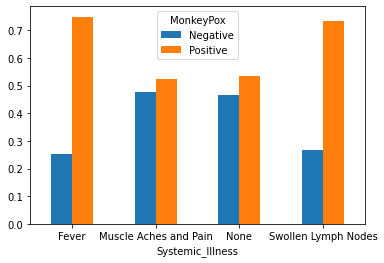

 
------------ RECTAL_PAIN ------------------
MonkeyPox    Negative  Positive
Rectal_Pain                    
False            5448      7207
True             3643      8702
 
MonkeyPox    Negative  Positive
Rectal_Pain                    
False        0.430502  0.569498
True         0.295099  0.704901


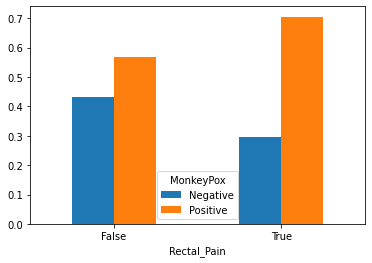

 
------------ SORE_THROAT ------------------
MonkeyPox    Negative  Positive
Sore_Throat                    
False            4907      7539
True             4184      8370
 
MonkeyPox    Negative  Positive
Sore_Throat                    
False        0.394263  0.605737
True         0.333280  0.666720


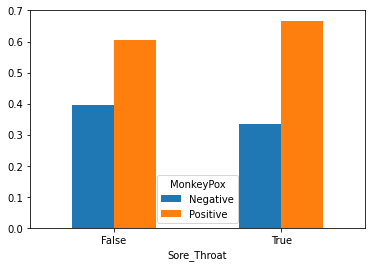

 
------------ PENILE_OEDEMA ------------------
MonkeyPox      Negative  Positive
Penile_Oedema                    
False              4877      7511
True               4214      8398
 
MonkeyPox      Negative  Positive
Penile_Oedema                    
False          0.393687  0.606313
True           0.334126  0.665874


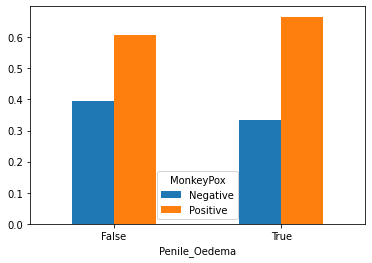

 
------------ ORAL_LESIONS ------------------
MonkeyPox     Negative  Positive
Oral_Lesions                    
False             4863      7651
True              4228      8258
 
MonkeyPox     Negative  Positive
Oral_Lesions                    
False         0.388605  0.611395
True          0.338619  0.661381


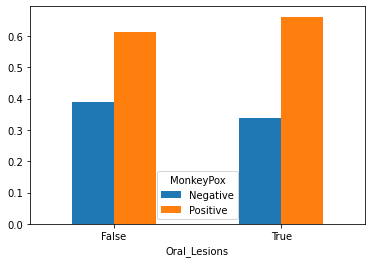

 
------------ SOLITARY_LESION ------------------
MonkeyPox        Negative  Positive
Solitary_Lesion                    
False                4761      7712
True                 4330      8197
 
MonkeyPox        Negative  Positive
Solitary_Lesion                    
False            0.381704  0.618296
True             0.345653  0.654347


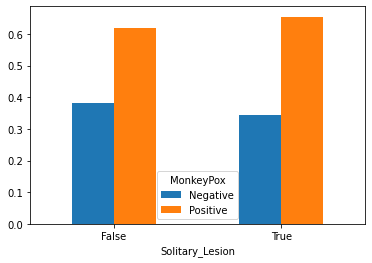

 
------------ SWOLLEN_TONSILS ------------------
MonkeyPox        Negative  Positive
Swollen_Tonsils                    
False                4613      7854
True                 4478      8055
 
MonkeyPox        Negative  Positive
Swollen_Tonsils                    
False            0.370017  0.629983
True             0.357297  0.642703


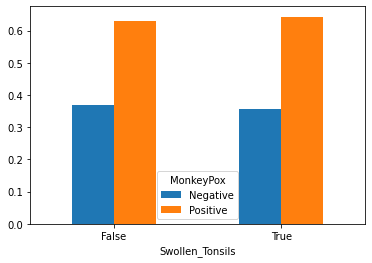

 
------------ HIV_INFECTION ------------------
MonkeyPox      Negative  Positive
HIV_Infection                    
False              5394      7022
True               3697      8887
 
MonkeyPox      Negative  Positive
HIV_Infection                    
False          0.434439  0.565561
True           0.293786  0.706214


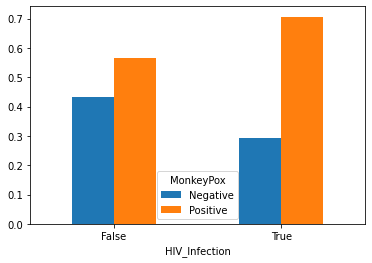

 
------------ SEXUALLY_TRANSMITTED_INFECTION ------------------
MonkeyPox                       Negative  Positive
Sexually_Transmitted_Infection                    
False                               5307      7247
True                                3784      8662
 
MonkeyPox                       Negative  Positive
Sexually_Transmitted_Infection                    
False                           0.422734  0.577266
True                            0.304033  0.695967


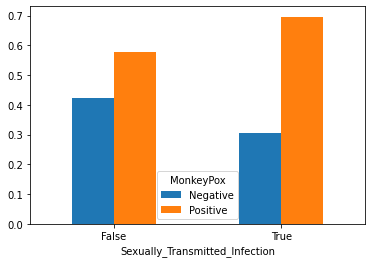

In [28]:
catgvars = ['Systemic_Illness','Rectal_Pain', 'Sore_Throat','Penile_Oedema', 'Oral_Lesions', 'Solitary_Lesion', 'Swollen_Tonsils',
        'HIV_Infection', 'Sexually_Transmitted_Infection']
for cvar in catgvars:
    print('------------',cvar.upper(),'------------------')
    tab = pd.crosstab(df[cvar],columns=df.MonkeyPox)
    print(tab)
    print(' ')
    rowtotal = tab.sum(axis =1)
    tab2 = tab.div(rowtotal,axis=0)
    print(tab2)
    tab2.plot.bar(rot=0)
    plt.show()
    print(' ')

## Obeservations

* Monkey Pox is higher among individuals with systemic illnesses Fever and Swollen Lymph nodes
* Monkey Pox is higher among people with rectal_pain compared to those who don't
* Sore throat, Penile oedema, oral lesions, solitary lesion, swollen tonsils doesn't seem to be making much difference in monkey pox prediction.
* Monkey Pox is higher among people who have HIV infection (Also sexually transmitted infections) compared to those who don't.

In [29]:
#convert before running
X_train, y_train = convertData(X_train, y_train)
X_valid, y_valid = convertData(X_valid, y_valid)

## Using DecisionTreeClassifier

In [30]:
#to find the best depth needed for decison tree. #hyper parameter testing

#get maximum depth
clf_tree = DecisionTreeClassifier(criterion = 'gini') #max_depth parameter best output at i=5
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_valid)
max_depth = clf_tree.get_depth()
print('max_depth:',max_depth)

#run for all the depth's and check the F1 scores
print("depth  f1_score  precision_score  recall_score  accuracy_score")
for i in range(1,max_depth+1):
    clf_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = i) #max_depth parameter best output at i=5
    clf_tree.fit(X_train, y_train)
    y_pred = clf_tree.predict(X_valid)
    print(i, round(f1_score(y_pred,y_valid),6),"  ",round(precision_score(y_pred,y_valid),6),"  ",round(recall_score(y_pred,y_valid),6),"  ",round(accuracy_score(y_pred,y_valid),6))    

max_depth: 10
depth  f1_score  precision_score  recall_score  accuracy_score
1 0.777058    1.0    0.6354    0.6354
2 0.756436    0.823104    0.699759    0.6632
3 0.781585    0.929808    0.674121    0.6698
4 0.769408    0.84073    0.709241    0.6798
5 0.780251    0.910293    0.68272    0.6742
6 0.772048    0.869374    0.694319    0.6738
7 0.776704    0.885741    0.69157    0.6764
8 0.765777    0.853636    0.694316    0.6682
9 0.760712    0.841045    0.694387    0.6638
10 0.752945    0.81492    0.69973    0.6602


#### It's observed that the best depth found is at 7 based on recall and accuracy.

#### Model 1

In [31]:
#Doing for depth 7 alone
clf_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 7) #max_depth parameter best output at i=5
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_valid)

#print the scores 
print("\n F1 score is: ",f1_score(y_pred,y_valid),"\n")    
print("\n precision_score is: ",precision_score(y_pred,y_valid),"\n")
print("\n recall_score is: ",recall_score(y_pred,y_valid),"\n")
print("\n accuracy_score is: ",accuracy_score(y_pred,y_valid),"\n")



 F1 score is:  0.7767043886282088 


 precision_score is:  0.8857412653446648 


 recall_score is:  0.6915704104202507 


 accuracy_score is:  0.6764 



## Using KNeighborsClassifier

In [32]:
print("depth  f1_score  precision_score  recall_score  accuracy_score")
for i in range(1,15):
    clf_knn = KNeighborsClassifier(n_neighbors=i) 
    clf_knn.fit(X_train, y_train)
    y_pred = clf_knn.predict(X_valid)
    print(i, round(f1_score(y_pred,y_valid),6),"  ",round(precision_score(y_pred,y_valid),6),"  ",round(recall_score(y_pred,y_valid),6),"  ",round(accuracy_score(y_pred,y_valid),6))    

depth  f1_score  precision_score  recall_score  accuracy_score
1 0.683718    0.689959    0.677589    0.5944
2 0.578723    0.492288    0.701975    0.5446
3 0.712758    0.744728    0.68342    0.6186
4 0.660587    0.627007    0.697968    0.5906
5 0.732345    0.785017    0.686296    0.6354
6 0.696386    0.688385    0.704575    0.6186
7 0.749131    0.813975    0.693856    0.6536
8 0.719975    0.734026    0.706453    0.6372
9 0.75036    0.819326    0.692103    0.6536
10 0.725955    0.756689    0.69762    0.637
11 0.753694    0.826881    0.692409    0.6566
12 0.738245    0.775889    0.704085    0.6504
13 0.756429    0.824048    0.699065    0.6628
14 0.746331    0.792257    0.705437    0.6578


#### We can choose K = 7 . It's almost consistent above that.

### Model 2

In [33]:
#Doing for k = 7
clf_knn = KNeighborsClassifier(n_neighbors=7) 
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_valid)

#print the scores for k=7.
print("\n F1 score is: ",f1_score(y_pred,y_valid),"\n")    
print("\n precision_score is: ",precision_score(y_pred,y_valid),"\n")
print("\n recall_score is: ",recall_score(y_pred,y_valid),"\n")
print("\n accuracy_score is: ",accuracy_score(y_pred,y_valid),"\n")



 F1 score is:  0.7491309385863267 


 precision_score is:  0.8139754485363551 


 recall_score is:  0.693855647974242 


 accuracy_score is:  0.6536 



## Conclusion
Recall score is same for both models. Precision is higher for model 1. Choosing model 1

## FINAL TEST DATA with model 1


 F1 score is:  0.7923076923076924 


 precision_score is:  0.90125 


 recall_score is:  0.7068627450980393 


 accuracy_score is:  0.6976 



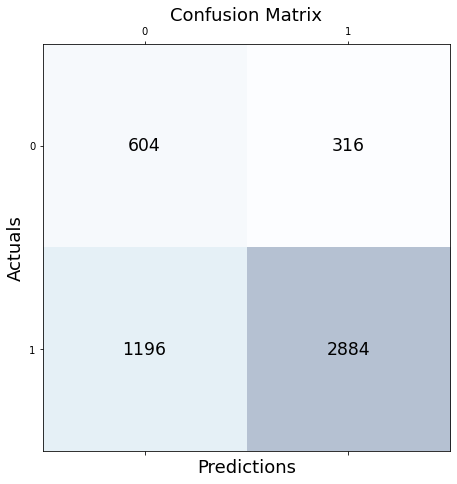

In [34]:
X_test, y_test = convertData(X_test, y_test)

y_test_pred = clf_tree.predict(X_test)

#Final scores with test data
print("\n F1 score is: ",f1_score(y_test_pred,y_test),"\n")    
print("\n precision_score is: ",precision_score(y_test_pred,y_test),"\n")
print("\n recall_score is: ",recall_score(y_test_pred,y_test),"\n")
print("\n accuracy_score is: ",accuracy_score(y_test_pred,y_test),"\n")

#below code for plotting confusion matrix
conf_mtx = confusion_matrix(y_test_pred,y_test)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_mtx, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mtx.shape[0]):
    for j in range(conf_mtx.shape[1]):
        ax.text(x=j, y=i,s=conf_mtx[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()